In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


### load packages

In [3]:
from tfumap.umap import UMAP_neural_network

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [7]:
from tensorflow.keras.datasets import fashion_mnist

In [8]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = fashion_mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

print(len(X_train), len(X_valid))

50000 10000


### Create model and train

In [9]:
embedder = UMAP_neural_network(
    decoding_method="autoencoder", 
    training_epochs=20,
    max_sample_repeats_per_epoch=10,
    valid_X = X_valid,
    valid_Y = Y_valid,
    verbose=True
)

In [10]:
z = embedder.fit_transform(X_train)

Construct fuzzy simplicial set
Sun May 31 16:33:02 2020 Finding Nearest Neighbors
Sun May 31 16:33:02 2020 Building RP forest with 16 trees
Sun May 31 16:33:04 2020 NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
Sun May 31 16:33:17 2020 Finished Nearest Neighbor Search
Sun May 31 16:33:20 2020 Embedding with TensorFlow


Sun May 31 16:37:53 2020 Finished embedding


### look at network architecture

In [11]:
embedder.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
z (Dense)                    (None, 2)                 202       
Total params: 98,902
Trainable params: 98,902
Non-trainable params: 0
_________________________________________________________________


In [12]:
embedder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 784)               79184     
_________________________________________________________________
reshape (Reshape)            (None, 784)               0         
Total params: 99,684
Trainable params: 99,684
Non-trainable params: 0
__________________________________________________

### Plot model output

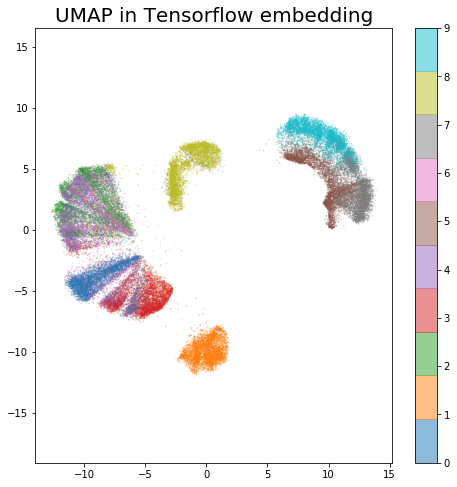

In [13]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### embed test data

In [14]:
z_test = embedder.transform(X_test)

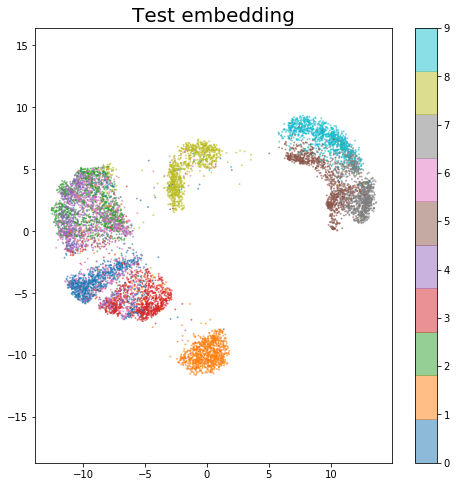

In [15]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z_test[:, 0],
    z_test[:, 1],
    c=Y_test.astype(int)[:len(z)],
    cmap="tab10",
    s=1.0,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("Test embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [16]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [17]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

['umap_loss', 'recon_loss']
['recon_loss']


,wall_time,step,val,group,variable
0,1.590968e+09,1,2.255943,train,umap_loss
1,1.590968e+09,2,1.816013,train,umap_loss
2,1.590968e+09,3,1.500586,train,umap_loss


In [18]:
loss_df.group.unique()

array(['train', 'valid'], dtype=object)

Text(0.5, 1.0, 'Reconstruction loss')

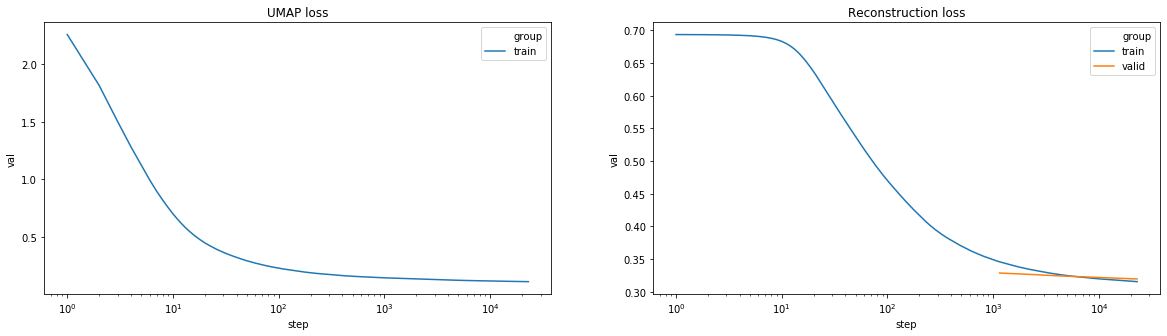

In [19]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))
ax = axs[0]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'], ax = ax)
ax.set_xscale('log')
ax.set_title('UMAP loss')

ax = axs[1]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='recon_loss'], ax = ax)
ax.set_xscale('log')
ax.set_title('Reconstruction loss')

### Compare to direct embedding with base UMAP

In [20]:
from umap import UMAP

In [21]:
z_umap = UMAP(verbose=True).fit_transform(X_train)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Sun May 31 16:38:05 2020 Finding Nearest Neighbors
Sun May 31 16:38:05 2020 Building RP forest with 16 trees
Sun May 31 16:38:05 2020 NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
Sun May 31 16:38:11 2020 Finished Nearest Neighbor Search
Sun May 31 16:38:11 2020 Construct embedding
	completed  0  /  200 epochs
	complet

In [22]:
### realign using procrustes 
from scipy.spatial import procrustes
z_align, z_umap_align, disparity = procrustes(z, z_umap)
print(disparity)

0.07159960083425398


Text(0.5, 1.0, 'UMAP with UMAP-learn')

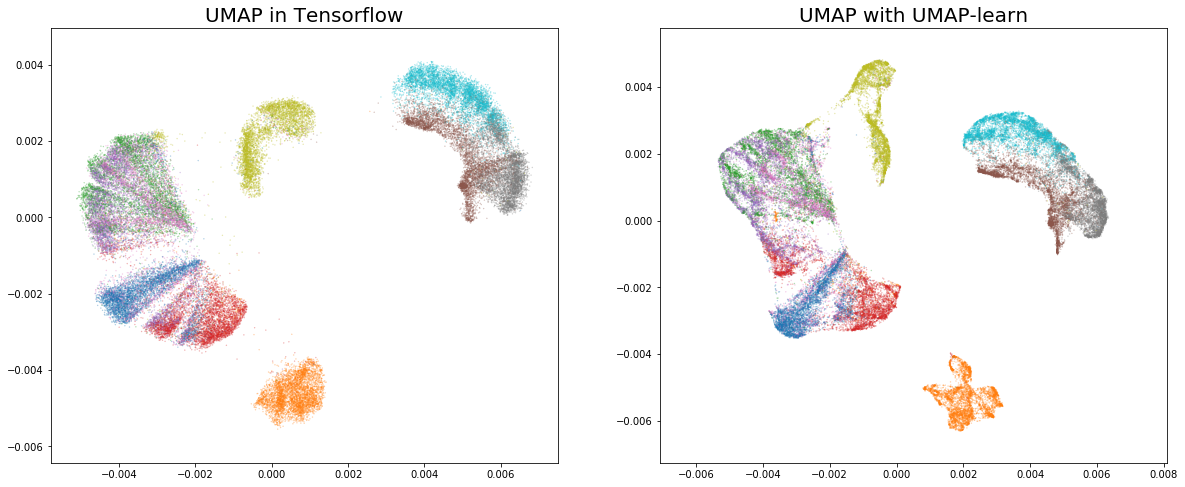

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
ax = axs[0]
sc = ax.scatter(
    z_align[:, 0],
    z_align[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow", fontsize=20)
#plt.colorbar(sc, ax=ax);

ax = axs[1]
sc = ax.scatter(
    z_umap_align[:, 0],
    z_umap_align[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP with UMAP-learn", fontsize=20)
#plt.colorbar(sc, ax=ax);

### View reconstructions on test data

In [24]:
X_test_recon = embedder.inverse_transform(z_test)

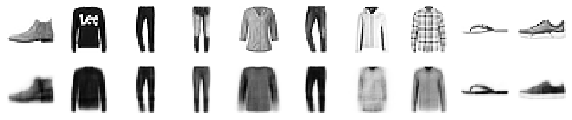

In [25]:
nex = 10
fig, axs = plt.subplots(ncols=nex, nrows=2, figsize=(nex,2))
for i in range(nex):
    axs[0,i].matshow(X_test[i].reshape(28,28), cmap='Greys')
    axs[1,i].matshow(X_test_recon[i].reshape(28,28), cmap="Greys")
for ax in axs.flatten():
    ax.axis('off')

### Show reconstructions over grid

In [26]:
embedding_x = z[:,0]
embedding_y = z[:,1]

In [28]:
### make a grid
max_tiles = 20
pct_coverage = 99.99 
xmin = np.percentile(embedding_x, (100-pct_coverage))
xmax = np.percentile(embedding_x, (pct_coverage))
ymin = np.percentile(embedding_y, (100-pct_coverage))
ymax = np.percentile(embedding_y, (pct_coverage))
print(xmin, xmax, ymin, ymax)

tile_spacing = np.max([xmax - xmin, ymax - ymin])/max_tiles
# add a little slack to tile around distribution
x_excess = tile_spacing * ((xmax - xmin) % tile_spacing) * 1.01 / 2
y_excess = tile_spacing * ((ymax - ymin) % tile_spacing) * 1.01 / 2

x_tiles = np.arange(xmin - x_excess, xmax + x_excess, tile_spacing)
y_tiles = np.arange(ymin - y_excess, ymax + y_excess, tile_spacing)[::-1]
x_tiled = np.repeat(x_tiles, len(y_tiles))
y_tiled = np.tile(y_tiles, len(x_tiles))
z_tiled = np.vstack([x_tiled, y_tiled]).T
print(x_tiles[0], x_tiles[-1], y_tiles[0], y_tiles[-1])

-12.54997382650372 13.710827248477903 -11.763273697948444 9.430025797176343
-13.42063128879216 14.153209839938535 9.12292274901141 -11.885718110973881


In [49]:
# reconstruct the grid
tiled_reconstructions = embedder.inverse_transform(z_tiled)
tiled_reconstructions = tiled_reconstructions.reshape((len(tiled_reconstructions), 28, 28))
tiled_reconstructions_rec = tiled_reconstructions.reshape(
    [len(x_tiles), len(y_tiles)] + list(tiled_reconstructions.shape[1:])
).squeeze()

recon_tiled = (
    tiled_reconstructions_rec.swapaxes(0, 1)
    .swapaxes(2, 1)
    .reshape(
        [
            tiled_reconstructions_rec.shape[1] * 28,
            tiled_reconstructions_rec.shape[0] * 28,
        ]
    )
)

(22, 17, 28, 28)

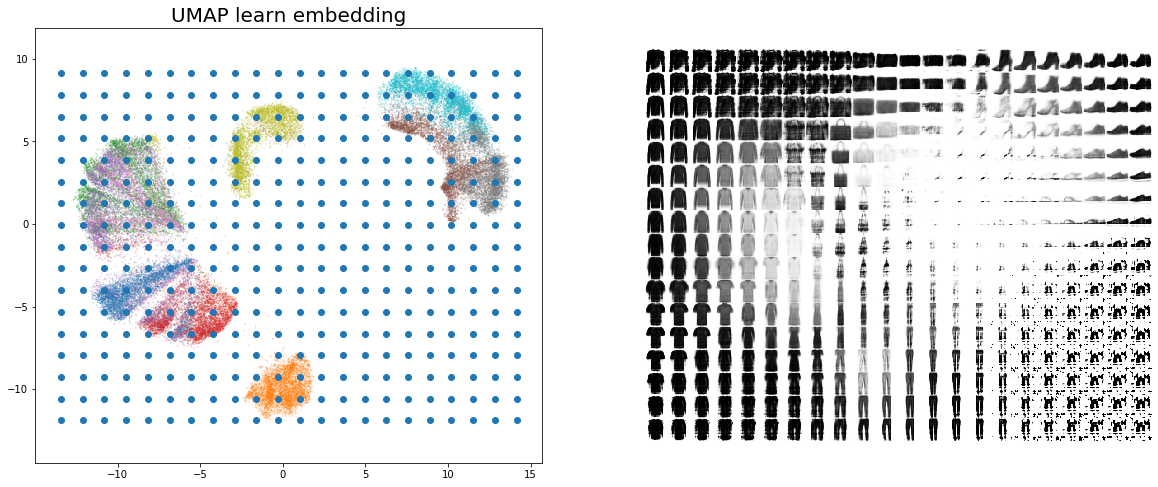

In [60]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
ax = axs[0]
sc = ax.scatter(
    embedding_x,
    embedding_y,
    c=Y_train.astype(int),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.set_title("Grid + Embeddings", fontsize=20)
#plt.colorbar(sc, ax=ax)
ax.axis('equal')
ax.scatter(x_tiled, y_tiled)
ax = axs[1]
ax.set_title("Reconstructions of grid", fontsize=20)

ax.matshow(recon_tiled, cmap = plt.cm.Greys)
ax.axis('off')
plt.show()